In [ ]:
# See E. Peterfreund, O. Lindenbaum, F. Dietrich, T. Bertalan, M. Gavish, I.G. Kevrekidis and R.R. Coifman,
# "LOCA: LOcal Conformal Autoencoder for standardized data coordinates",
# https://www.pnas.org/doi/full/10.1073/pnas.2014627117
#
#
# -----------------------------------------------------------------------------
# Author: Erez Peterfreund , Ofir Lindenbaum
#         erezpeter@gmail.com  , ofir.lindenbaum@yale.edu , 2020
# 
# This program is free software: you can redistribute it and/or modify it under
# the terms of the GNU General Public License as published by the Free Software
# Foundation, either version 3 of the License, or (at your option) any later
# version.
#
# This program is distributed in the hope that it will be useful, but WITHOUT
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more
# details.
#
# You should have received a copy of the GNU General Public License along with
# this program.  If not, see <http://www.gnu.org/licenses/>.
# -----------------------------------------------------------------------------

In [3]:
# import necessary packages 
import scipy

import numpy as np
import matplotlib.pyplot as plt

from utils import *
from Loca import *

# Generate data and divide into train and validation

In [ ]:
# The function generates points in a frame (0,1)^2\ [0.1,0.9]^2 alongside bursts of size additionalPointPerSample around these
# points (if additionalPointPerSample is supplied). i.e. a burst around x_i will be defined by sampling a Gaussian distribution
# with x_i as the mean and I* additionalPointsStd**2 as its covariance matrix.
# 
# Input:
#         n- integer. Amount of points.
#         additionalPointPerSample (Optional)- integer. Amount of points in a burst.
#         additionalPointsStd - float. The std that defines the burst. 
#
# Output:
#        x - n-by-2 array. The points sampled on the frame.
#        additionalDataX (If additionalPointPerSample is not None) - n-by-additionalPointPerSample-by-2. The bursts.
def generate_x_hole(n=900, additionalPointPerSample= None, additionalPointsStd=1e-2):
    x= np.random.uniform(-0.5,0.5,(10*n,2))
    goodIndxs= np.max(np.abs(x),axis=1)>0.4
    while np.sum(goodIndxs)<n:
        x= np.random.uniform(-0.5,0.5,(5*n,2))
        goodIndxs= np.max(np.abs(x),axis=1)>0.4

    x=x[goodIndxs,:][:n,:]
    x=x+0.5
        
        
    if additionalPointPerSample is not None:
        additionalDataX= x.reshape((n,1,2)).repeat(additionalPointPerSample,axis=1)
        
        noise = np.random.randn(n,additionalPointPerSample,2)*additionalPointsStd
        additionalDataX+=noise
        return x,additionalDataX
    return x



In [56]:
# The non linear function that is applied to the latent data.
#
# Input:
#          data- n-by-2 or n-by-m-by-2 tensor. The dataset input that contatins n or n*m datapoints in dimension 2.
# 
# Output:
#          new_data- n-by-2 or n-by-m-by-2 tensor (According to data's structure)
def non_linear_function(x):
    y=np.zeros(np.shape(x))
    
    y[...,0]= x[...,0]+x[...,1]**3
    y[...,1]= x[...,1]-x[...,0]**3

    return y
    


In [3]:
N=2000
M= 200
n_std=0.01


x,additionalDataX=generate_x_hole(n=N, additionalPointPerSample=M,additionalPointsStd=n_std)

y= non_linear_function(x)
additionalDataY= non_linear_function(additionalDataX)

In [5]:
# Divide into train and validation
indexes = np.random.permutation(N)
indexes_train, indexes_val = indexes[:N*9//10], indexes[N*9//10:]

data_train = additionalDataY[indexes_train,:,:]
data_val = additionalDataY[indexes_val,:,:]

# Define and train the neural net

In [6]:
amount_epochs=20000
params = {}
params['encoder_layers']=[2,50,50,2,2]
params['decoder_layers']=[2,50,50,2,2]

params['activation_enc']='tanh'
params['activation_dec']='tanh'

params['clouds_var']= n_std**2

In [7]:
batch_size=200
lrs= [1e-3,3e-4,1e-4]


model = Loca(**params) 

for lr in lrs:
    model.train( data_train,amount_epochs,lr=lr, batch_size=batch_size, data_val=data_val, evaluate_every=100,verbose=True)

Epoch: 0100 Train : white= 1.46763 rec=0.34349      Val: : white= 1.49565 rec=0.33881
Epoch: 0200 Train : white= 1.35442 rec=0.30401      Val: : white= 1.35177 rec=0.30830
Epoch: 0300 Train : white= 1.12349 rec=0.30235      Val: : white= 1.12334 rec=0.30743
Epoch: 0400 Train : white= 1.03707 rec=0.27920      Val: : white= 1.03353 rec=0.28068
Epoch: 0500 Train : white= 1.05019 rec=0.25590      Val: : white= 1.04646 rec=0.25120
Epoch: 0600 Train : white= 1.06954 rec=0.21823      Val: : white= 1.06893 rec=0.21652
Epoch: 0700 Train : white= 1.21834 rec=0.18505      Val: : white= 1.22384 rec=0.18360
Epoch: 0800 Train : white= 1.28076 rec=0.14038      Val: : white= 1.28150 rec=0.14656
Epoch: 0900 Train : white= 0.56155 rec=0.02124      Val: : white= 0.55723 rec=0.01798
Epoch: 1000 Train : white= 0.15784 rec=0.01204      Val: : white= 0.16584 rec=0.01010
Epoch: 1100 Train : white= 0.09948 rec=0.00995      Val: : white= 0.10555 rec=0.00840
Epoch: 1200 Train : white= 0.07665 rec=0.00659      Va

Epoch: 9700 Train : white= 0.03445 rec=0.00013      Val: : white= 0.03328 rec=0.00013
Epoch: 9800 Train : white= 0.03513 rec=0.00003      Val: : white= 0.03424 rec=0.00003
Epoch: 9900 Train : white= 0.03482 rec=0.00014      Val: : white= 0.03398 rec=0.00014
Epoch: 10000 Train : white= 0.03481 rec=0.00009      Val: : white= 0.03419 rec=0.00008
Epoch: 10100 Train : white= 0.03539 rec=0.00019      Val: : white= 0.03406 rec=0.00018
Epoch: 10200 Train : white= 0.03497 rec=0.00017      Val: : white= 0.03491 rec=0.00016
Epoch: 10300 Train : white= 0.03400 rec=0.00024      Val: : white= 0.03417 rec=0.00022
Epoch: 10400 Train : white= 0.03347 rec=0.00008      Val: : white= 0.03308 rec=0.00007
Epoch: 10500 Train : white= 0.03345 rec=0.00007      Val: : white= 0.03272 rec=0.00006
Epoch: 10600 Train : white= 0.03357 rec=0.00005      Val: : white= 0.03332 rec=0.00005
Epoch: 10700 Train : white= 0.03396 rec=0.00004      Val: : white= 0.03384 rec=0.00004
Epoch: 10800 Train : white= 0.03376 rec=0.0001

Epoch: 19200 Train : white= 0.03371 rec=0.00009      Val: : white= 0.03315 rec=0.00009
Epoch: 19300 Train : white= 0.03439 rec=0.00021      Val: : white= 0.03398 rec=0.00020
Epoch: 19400 Train : white= 0.03458 rec=0.00015      Val: : white= 0.03442 rec=0.00015
Epoch: 19500 Train : white= 0.03444 rec=0.00055      Val: : white= 0.03413 rec=0.00053
Epoch: 19600 Train : white= 0.03455 rec=0.00009      Val: : white= 0.03434 rec=0.00009
Epoch: 19700 Train : white= 0.03422 rec=0.00005      Val: : white= 0.03396 rec=0.00004
Epoch: 19800 Train : white= 0.03444 rec=0.00018      Val: : white= 0.03409 rec=0.00017
Epoch: 19900 Train : white= 0.03423 rec=0.00004      Val: : white= 0.03378 rec=0.00003
Epoch: 20000 Train : white= 0.03462 rec=0.00004      Val: : white= 0.03403 rec=0.00004
Epoch: 20100 Train : white= 0.03243 rec=0.00004      Val: : white= 0.03150 rec=0.00004
Epoch: 20200 Train : white= 0.03233 rec=0.00004      Val: : white= 0.03139 rec=0.00004
Epoch: 20300 Train : white= 0.03225 rec=0.0

Epoch: 28700 Train : white= 0.03237 rec=0.00003      Val: : white= 0.03293 rec=0.00003
Epoch: 28800 Train : white= 0.03235 rec=0.00002      Val: : white= 0.03293 rec=0.00002
Epoch: 28900 Train : white= 0.03238 rec=0.00005      Val: : white= 0.03290 rec=0.00005
Epoch: 29000 Train : white= 0.03232 rec=0.00002      Val: : white= 0.03287 rec=0.00002
Epoch: 29100 Train : white= 0.03232 rec=0.00004      Val: : white= 0.03286 rec=0.00003
Epoch: 29200 Train : white= 0.03231 rec=0.00002      Val: : white= 0.03282 rec=0.00001
Epoch: 29300 Train : white= 0.03232 rec=0.00002      Val: : white= 0.03282 rec=0.00002
Epoch: 29400 Train : white= 0.03233 rec=0.00004      Val: : white= 0.03282 rec=0.00004
Epoch: 29500 Train : white= 0.03231 rec=0.00001      Val: : white= 0.03282 rec=0.00001
Epoch: 29600 Train : white= 0.03230 rec=0.00002      Val: : white= 0.03281 rec=0.00002
Epoch: 29700 Train : white= 0.03227 rec=0.00003      Val: : white= 0.03278 rec=0.00003
Epoch: 29800 Train : white= 0.03223 rec=0.0

Epoch: 38200 Train : white= 0.03134 rec=0.00001      Val: : white= 0.03162 rec=0.00001
Epoch: 38300 Train : white= 0.03135 rec=0.00004      Val: : white= 0.03162 rec=0.00004
Epoch: 38400 Train : white= 0.03132 rec=0.00001      Val: : white= 0.03156 rec=0.00001
Epoch: 38500 Train : white= 0.03134 rec=0.00001      Val: : white= 0.03157 rec=0.00001
Epoch: 38600 Train : white= 0.03133 rec=0.00002      Val: : white= 0.03160 rec=0.00002
Epoch: 38700 Train : white= 0.03133 rec=0.00001      Val: : white= 0.03160 rec=0.00001
Epoch: 38800 Train : white= 0.03136 rec=0.00001      Val: : white= 0.03159 rec=0.00001
Epoch: 38900 Train : white= 0.03138 rec=0.00002      Val: : white= 0.03164 rec=0.00002
Epoch: 39000 Train : white= 0.03137 rec=0.00001      Val: : white= 0.03162 rec=0.00001
Epoch: 39100 Train : white= 0.03135 rec=0.00002      Val: : white= 0.03163 rec=0.00002
Epoch: 39200 Train : white= 0.03135 rec=0.00002      Val: : white= 0.03163 rec=0.00002
Epoch: 39300 Train : white= 0.03138 rec=0.0

Epoch: 47700 Train : white= 0.03360 rec=0.00002      Val: : white= 0.03408 rec=0.00002
Epoch: 47800 Train : white= 0.03360 rec=0.00002      Val: : white= 0.03409 rec=0.00002
Epoch: 47900 Train : white= 0.03360 rec=0.00002      Val: : white= 0.03409 rec=0.00002
Epoch: 48000 Train : white= 0.03360 rec=0.00002      Val: : white= 0.03409 rec=0.00002
Epoch: 48100 Train : white= 0.03361 rec=0.00002      Val: : white= 0.03410 rec=0.00002
Epoch: 48200 Train : white= 0.03362 rec=0.00002      Val: : white= 0.03410 rec=0.00002
Epoch: 48300 Train : white= 0.03362 rec=0.00001      Val: : white= 0.03411 rec=0.00002
Epoch: 48400 Train : white= 0.03362 rec=0.00002      Val: : white= 0.03410 rec=0.00002
Epoch: 48500 Train : white= 0.03363 rec=0.00002      Val: : white= 0.03412 rec=0.00002
Epoch: 48600 Train : white= 0.03364 rec=0.00001      Val: : white= 0.03412 rec=0.00002
Epoch: 48700 Train : white= 0.03364 rec=0.00001      Val: : white= 0.03413 rec=0.00002
Epoch: 48800 Train : white= 0.03364 rec=0.0

Epoch: 57200 Train : white= 0.03194 rec=0.00001      Val: : white= 0.03218 rec=0.00001
Epoch: 57300 Train : white= 0.03194 rec=0.00001      Val: : white= 0.03217 rec=0.00001
Epoch: 57400 Train : white= 0.03194 rec=0.00001      Val: : white= 0.03216 rec=0.00001
Epoch: 57500 Train : white= 0.03194 rec=0.00001      Val: : white= 0.03216 rec=0.00002
Epoch: 57600 Train : white= 0.03193 rec=0.00001      Val: : white= 0.03215 rec=0.00001
Epoch: 57700 Train : white= 0.03194 rec=0.00001      Val: : white= 0.03215 rec=0.00001
Epoch: 57800 Train : white= 0.03194 rec=0.00001      Val: : white= 0.03215 rec=0.00001
Epoch: 57900 Train : white= 0.03194 rec=0.00001      Val: : white= 0.03215 rec=0.00001
Epoch: 58000 Train : white= 0.03194 rec=0.00001      Val: : white= 0.03215 rec=0.00001
Epoch: 58100 Train : white= 0.03194 rec=0.00001      Val: : white= 0.03216 rec=0.00001
Epoch: 58200 Train : white= 0.03194 rec=0.00001      Val: : white= 0.03215 rec=0.00001
Epoch: 58300 Train : white= 0.03194 rec=0.0

# Training set- Latent and Ambient space

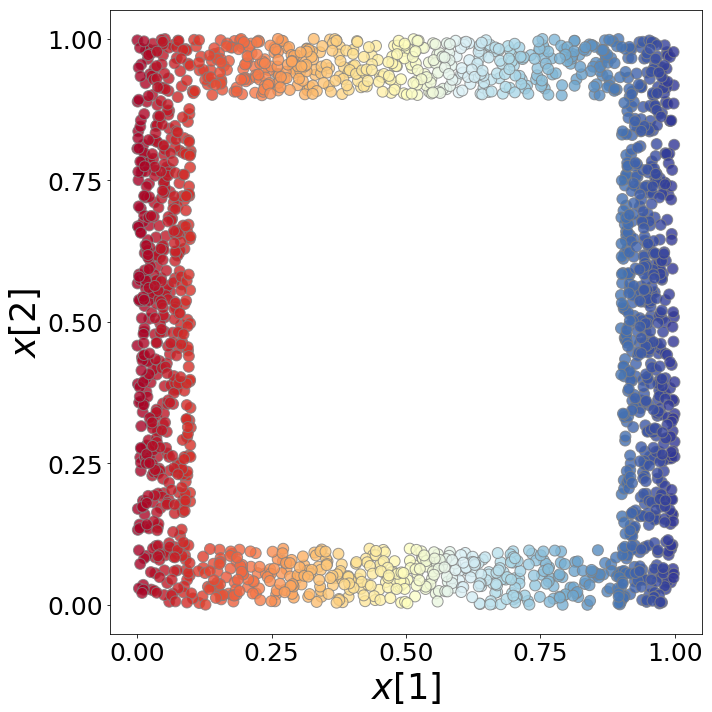

In [30]:
f,ax = plt.subplots(1,1,figsize=(10,10))
plt.tick_params(labelsize=25)
plt.xlabel(r'$x[1]$',fontsize=35)
plt.ylabel(r'$x[2]$',fontsize=35)
plt.locator_params(nbins=5)


ax.scatter(x=x[:,0], y=x[:,1], s=120, c=x[:,0],alpha=0.8,\
           cmap=plt.cm.get_cmap('RdYlBu'),edgecolors= "grey" )


plt.tight_layout()


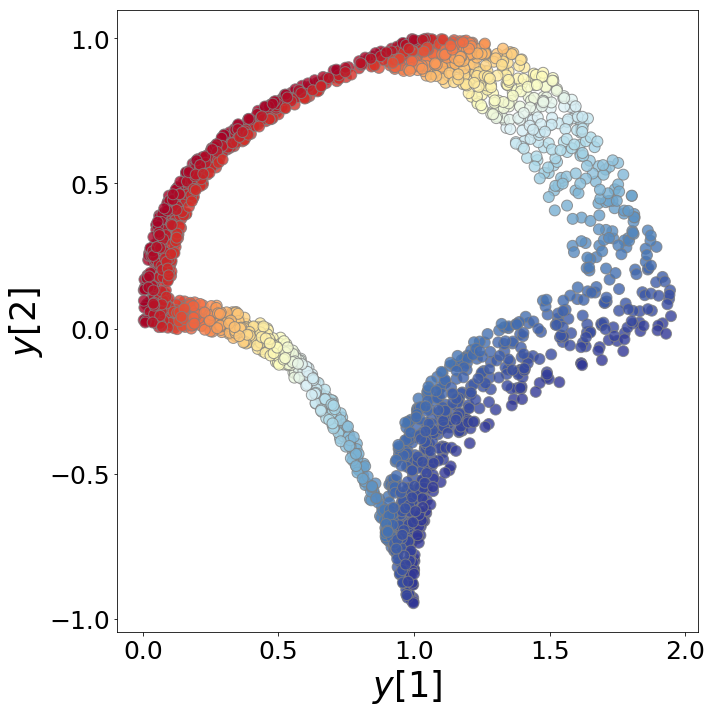

In [31]:
f,ax = plt.subplots(1,1,figsize=(10,10))
plt.tick_params(labelsize=25)
plt.xlabel(r'$y[1]$',fontsize=35)
plt.ylabel(r'$y[2]$',fontsize=35)
plt.locator_params(nbins=5)


ax.scatter(x=y[:,0], y=y[:,1], s=120, c=x[:,0],alpha=0.8,\
           cmap=plt.cm.get_cmap('RdYlBu'),edgecolors= "grey" )


plt.tight_layout()


# Experiment 6B

In [32]:
# Generating corresponding points on each edge of the outer boundary of the frame
Nl=500
frame_d=np.vstack((np.zeros(Nl),np.linspace(0,1,Nl)))
frame_u=np.vstack((np.ones(Nl),np.linspace(0,1,Nl)))
frame_l=np.vstack((np.linspace(0,1,Nl),np.zeros(Nl)))
frame_r=np.vstack((np.linspace(0,1,Nl) ,np.ones(Nl)))
frame_outside=np.hstack((frame_u,frame_l,frame_d,frame_r)).T


# Generating corresponding points on each edge of the inner boundary of the frame
Nl=500
frame_d=np.vstack((0.1+np.zeros(Nl),np.linspace(0.1,0.9,Nl)))
frame_u=np.vstack((np.ones(Nl)-0.1,np.linspace(0.1,0.9,Nl)))
frame_l=np.vstack((np.linspace(0.1,0.9,Nl),np.zeros(Nl)+0.1))
frame_r=np.vstack((np.linspace(0.1,0.9,Nl) ,np.ones(Nl)-0.1))
frame_inside=np.hstack((frame_u,frame_l,frame_d,frame_r)).T


In [33]:
y_frame_outside=non_linear_function(frame_outside)
y_frame_inside= non_linear_function(frame_inside)

## Fig 4a - Latent space - Generate points in the latent space

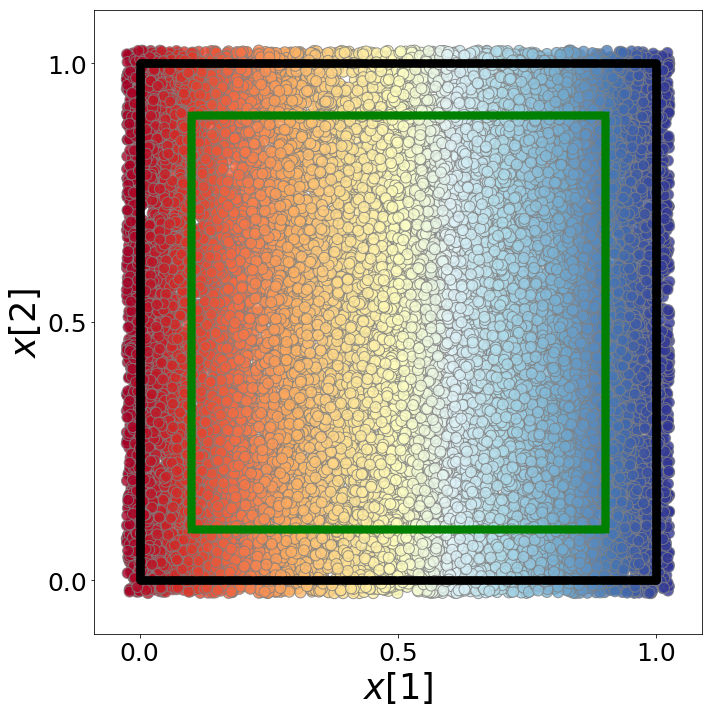

In [34]:
N_oos= N*10

perc_extend= .25

x_xtra= np.random.rand(N_oos,2)*(1+0.1*perc_extend*2) - 0.1*perc_extend
y_xtra= non_linear_function(x_xtra)


f,ax = plt.subplots(1,1,figsize=(10,10))
cm= plt.cm.get_cmap('RdYlBu')

ax.scatter(x=x_xtra[:,0], y=x_xtra[:,1], s=120, c=x_xtra[:,0],alpha=0.8,cmap=plt.cm.get_cmap('RdYlBu'),edgeColor='grey')

plt.scatter(x=frame_outside[:,0], y=frame_outside[:,1], s=50, c='k',cmap=cm,)
plt.scatter(x=frame_inside[:,0], y=frame_inside[:,1], s=50, c='g',cmap=cm,marker='x')



plt.xlabel('${x}[1]$',fontsize=35)
plt.ylabel('${x}[2]$',fontsize=35)

plt.xticks([0,0.5,1])
plt.yticks([0,0.5,1])
plt.tick_params(labelsize=25)
plt.axis('equal')

plt.tight_layout()

## Fig 4b - Ambient space

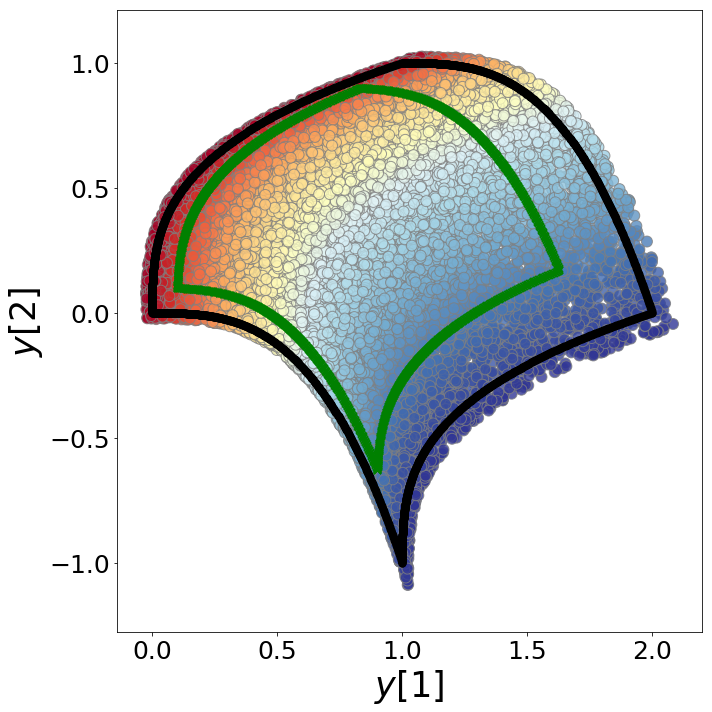

In [35]:
f,ax = plt.subplots(1,1,figsize=(10,10))
        

ax.scatter(x=y_xtra[:,0], y=y_xtra[:,1], s=120, c=x_xtra[:,0],alpha=0.8,cmap=plt.cm.get_cmap('RdYlBu'),edgeColor='grey')

plt.scatter(x= y_frame_outside[:,0], y= y_frame_outside[:,1], s=50, c='k',cmap=cm,)
plt.scatter(x= y_frame_inside[:,0], y= y_frame_inside[:,1], s=50, c='g',cmap=cm,marker='x')


plt.xlabel('${y}[1]$',fontsize=35)
plt.ylabel('${y}[2]$',fontsize=35)

plt.locator_params(nbins=5)

plt.tick_params(labelsize=25)
plt.axis('equal')

plt.tight_layout()

## Fig 4c - Embedding space

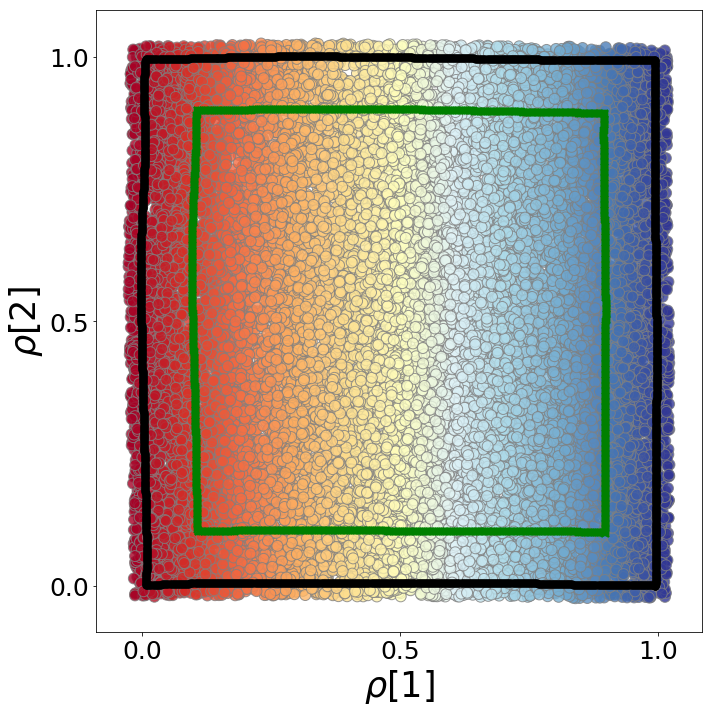

In [37]:
import matplotlib

embedding,recon = model.test(y)
embedding_ext,_= model.test(y_xtra)
embedding_frame_outside,_ = model.test(y_frame_outside)
embedding_frame_inside,_ = model.test(y_frame_inside)


R,bias = calibrate_data_b(x,embedding)

calibrated_emb_extra = np.dot(embedding_ext,R)+bias
calibrated_emb_frame_outside = np.dot(embedding_frame_outside,R)+bias
calibrated_emb_frame_inside = np.dot(embedding_frame_inside,R)+bias


f,ax = plt.subplots(1,1,figsize=(10,10))
        
cm = matplotlib.cm.get_cmap('RdYlBu')
colors=[cm(1.*i/20) for i in range(20)]
xy = range(20)
plt.scatter(x=calibrated_emb_extra[:,0], y=calibrated_emb_extra[:,1], s=120, c=x_xtra[:,0],\
            cmap=cm,alpha=0.8, edgecolor='grey')


plt.scatter(x=calibrated_emb_frame_outside[:,0], y=calibrated_emb_frame_outside[:,1], s=50, c='k',cmap=cm,)
plt.scatter(x=calibrated_emb_frame_inside[:,0], y=calibrated_emb_frame_inside[:,1], s=50, c='g',cmap=cm,marker='x')

plt.xlabel(r'$\rho[1]$',fontsize=35)
plt.ylabel(r'$\rho[2]$',fontsize=35)
plt.locator_params(nbins=4)

plt.tick_params(labelsize=25)
plt.tight_layout()

## Fig 4d - Distance comparison

In [38]:
indexes_in_frame= np.where(np.sum(np.abs(x_xtra-0.5)<0.4, axis=1)==2)[0]
indexes_out_frame= np.where(np.sum(np.abs(x_xtra-0.5)>0.5, axis=1)>0)[0]


indexes_frame= np.where(np.sum(np.abs(x_xtra-.5)<0.5 , axis=1)==2)[0]
indexes_frame= indexes_frame[ np.where(np.sum(np.abs(x_xtra[indexes_frame,:]-.5)>0.4 , axis=1)>0)[0]  ]

In [39]:
m=1000
in_frame_dists = scipy.spatial.distance.pdist(x_xtra[indexes_in_frame[:m],:])
out_frame_dists = scipy.spatial.distance.pdist(x_xtra[indexes_out_frame[:m],:])
frame_dists = scipy.spatial.distance.pdist(x_xtra[indexes_frame[:m],:])

in_frame_dists_loca = scipy.spatial.distance.pdist(embedding_ext[indexes_in_frame[:m],:])
out_frame_dists_loca = scipy.spatial.distance.pdist(embedding_ext[indexes_out_frame[:m],:])
frame_dists_loca = scipy.spatial.distance.pdist(embedding_ext[indexes_frame[:m],:])


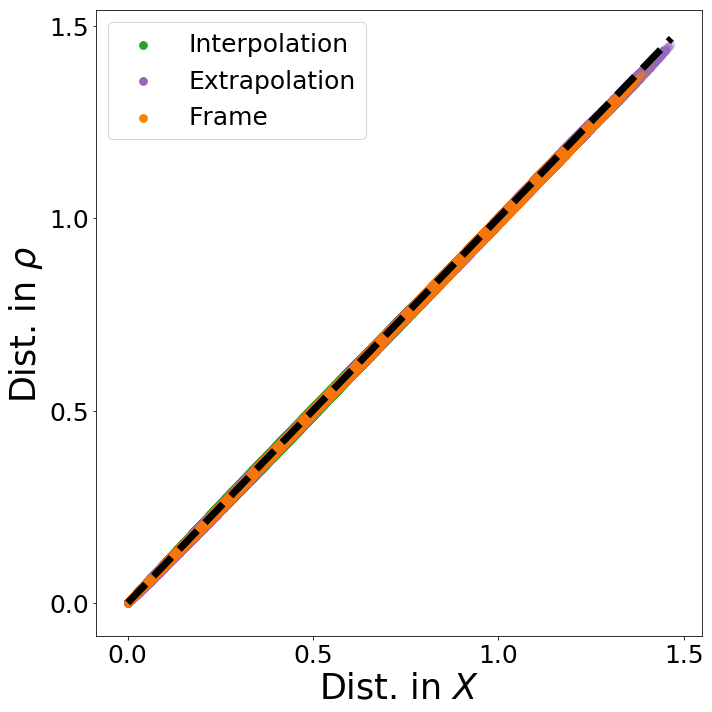

In [40]:
plt.figure(figsize=(10,10))
plt.scatter(in_frame_dists,(in_frame_dists_loca), c='#2ca02c', label='Interpolation', s=60,alpha=0.1)
plt.scatter(out_frame_dists,(out_frame_dists_loca), c='#9467bd', label='Extrapolation', s=60,alpha=0.1)
plt.scatter(frame_dists,(frame_dists_loca), c='#ff7f0e', label='Frame', s=60,alpha=0.1)
plt.plot([np.min(out_frame_dists), np.max(out_frame_dists)],[np.min(out_frame_dists), np.max(out_frame_dists)],'--',linewidth=7,c='black')
plt.xlabel(r'Dist. in $X$',fontsize=35)
plt.ylabel(r'Dist. in $\rho$',fontsize=35)
leg= plt.legend(fontsize=25)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.tick_params(labelsize=25)

plt.locator_params(nbins=4)

plt.tight_layout()

In [41]:
print('MSE dists- Interpolation: ')
print(np.mean((in_frame_dists-in_frame_dists_loca)**2))
print('MSE dists- Extrapolation:')
print(np.mean((out_frame_dists-out_frame_dists_loca)**2))
print('MSE dists- On frame')
print(np.mean((frame_dists-frame_dists_loca)**2))

MSE dists- Interpolation: 
2.3395137806625935e-05
MSE dists- Extrapolation:
4.235115245609384e-05
MSE dists- On frame
3.491135290309055e-05


# Experiment 6C- Interpolating in the latent space

In [42]:
embedding, recon = model.test(y)

In [43]:
# Generating points on the inner part of the frame ( Each point in x_points_inter1 is generated along with a 
# a corresponding point in x_points_inter2 that is on a parrallel edge of the inner frame)
delta = np.linspace(0.1,0.9,100)
x_points_inter1= np.zeros((200,2))
x_points_inter2= np.zeros((200,2))
x_points_inter1[:100,0]=0.1
x_points_inter1[:100,1]=delta
x_points_inter2[:100,0]=0.9
x_points_inter2[:100,1]=delta
x_points_inter1[100:,0]=delta
x_points_inter1[100:,1]=0.1
x_points_inter2[100:,0]=delta
x_points_inter2[100:,1]=0.9



# Applying the non-linear transformation on both set of points and embedding them using the learned model, which used
# training data from the frame itself
y_points_inter1=non_linear_function(x_points_inter1)
y_points_inter2=non_linear_function(x_points_inter2)

emb1,recon1 = model.test(y_points_inter1)
emb2,recon2 = model.test(y_points_inter2)

In [44]:
# Constructing the interpolation in the latent space and pushing it forward using the non linear function
x_inter = interpolate(x_points_inter1,x_points_inter2)
additionalDataY_inter = non_linear_function(x_inter)

emb_inter= interpolate(emb1,emb2)
emb_inter_recon= model.decode(emb_inter)


colors=['pink','grey','white','purple']

## Fig 5a - Latent space

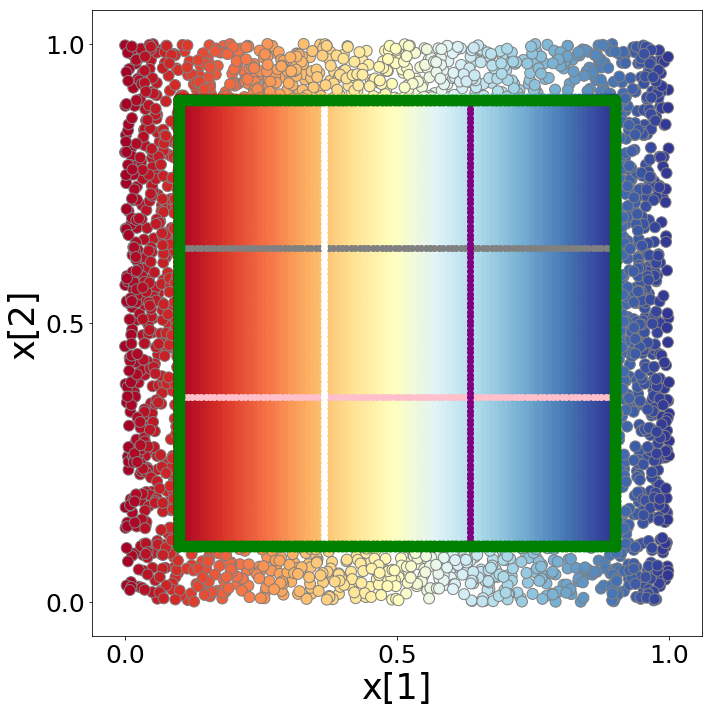

In [45]:
import matplotlib
cm = matplotlib.cm.get_cmap('RdYlBu')

plt.figure(figsize=(10,10))
plt.scatter(x[:,0],x[:,1],c=x[:,0],cmap=cm,s=120, edgecolor='grey')
plt.scatter(x_inter[:,:,0],x_inter[:,:,1],c=x_inter[:,:,0],cmap=cm,s=120)#'green')


for index,i in enumerate([33,66,133,166]):
    plt.scatter(x_inter[i,:,0],x_inter[i,:,1], c=colors[index],  cmap=cm)


plt.scatter(x_points_inter1[:,0],x_points_inter1[:,1], c='green',cmap=cm,s=120)
plt.scatter(x_points_inter2[:,0],x_points_inter2[:,1], c='green',cmap=cm,s=120)


plt.xlabel('x[1]',fontsize=35)
plt.ylabel('x[2]',fontsize=35)
plt.locator_params(nbins=4)
plt.tick_params(labelsize=25)
plt.tight_layout()


## Fig 5b - Ambient space

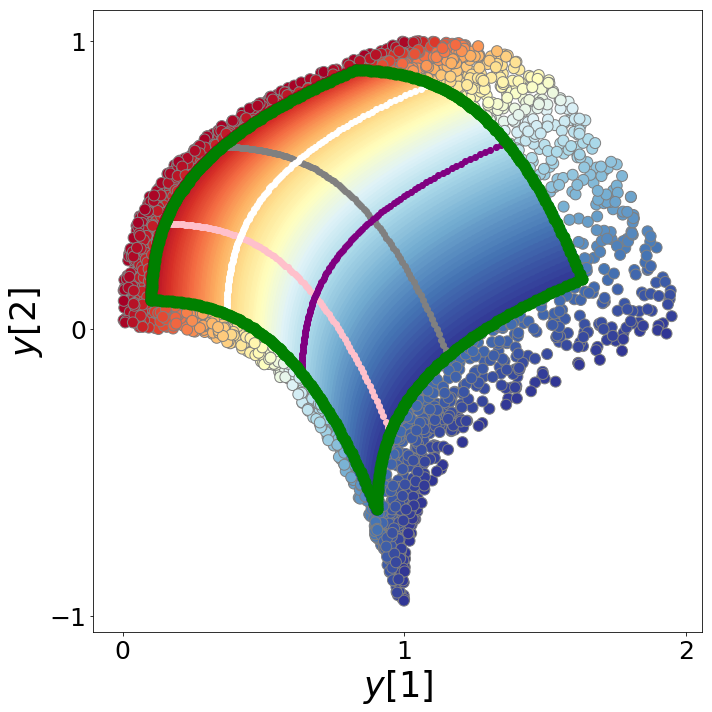

In [46]:
plt.figure(figsize=(10,10))
plt.scatter(y[:,0],y[:,1],c=x[:,0],cmap=cm,s=120, edgecolor='grey')

plt.scatter(additionalDataY_inter[:,:,0],additionalDataY_inter[:,:,1],c=x_inter[:,:,0],cmap=cm,s=120),

for index,i in enumerate([33,66,133,166]):
    plt.scatter(additionalDataY_inter[i,:,0],additionalDataY_inter[i,:,1], c=colors[index],  cmap=cm)    

plt.scatter(y_points_inter1[:,0],y_points_inter1[:,1], c='green',cmap=cm,s=120)
plt.scatter(y_points_inter2[:,0],y_points_inter2[:,1], c='green',cmap=cm, s=120)


plt.xlabel(r'$y$[1]',fontsize=35)
plt.ylabel(r'$y$[2]',fontsize=35)

plt.locator_params(nbins=4)
plt.tick_params(labelsize=25)
plt.tight_layout()



## Fig 5c - Embedding space

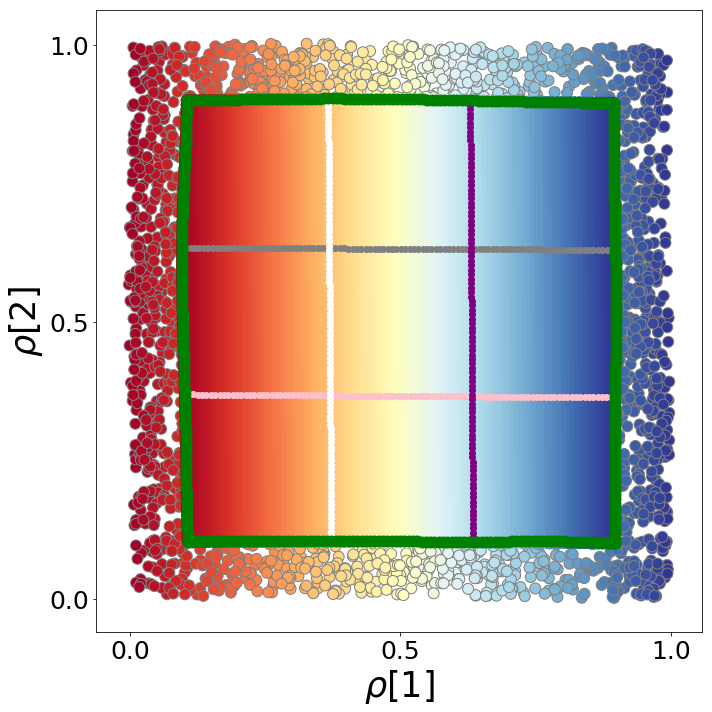

In [47]:
R,bias = calibrate_data_b(x, embedding) 
calibrated_embedding = np.dot(embedding,R)+bias
calibrated_embedding_inter= np.dot(emb_inter,R)+bias
calibrated_emb1 = np.dot(emb1,R)+bias
calibrated_emb2 = np.dot(emb2,R)+bias


plt.figure(figsize=(10,10))
plt.scatter(calibrated_embedding[:,0],calibrated_embedding[:,1],c=x[:,0],cmap=cm,s=120, edgecolor='grey')

plt.scatter(calibrated_embedding_inter[:,:,0],calibrated_embedding_inter[:,:,1],c=x_inter[:,:,0],cmap=cm,s=120)#c='green')

for index,i in enumerate([33,66,133,166]):
    plt.scatter(calibrated_embedding_inter[i,:,0],calibrated_embedding_inter[i,:,1], c=colors[index],  cmap=cm)    
    
plt.scatter(calibrated_emb1[:,0],calibrated_emb1[:,1], c='green',cmap=cm,s=120)
plt.scatter(calibrated_emb2[:,0],calibrated_emb2[:,1], c='green',cmap=cm,s=120)

    
plt.xlabel(r'$\rho$[1]',fontsize=35)
plt.ylabel(r'$\rho$[2]',fontsize=35)

plt.locator_params(nbins=4)
plt.tick_params(labelsize=25)
plt.tight_layout()


## Fig 5d - Reconstruction space

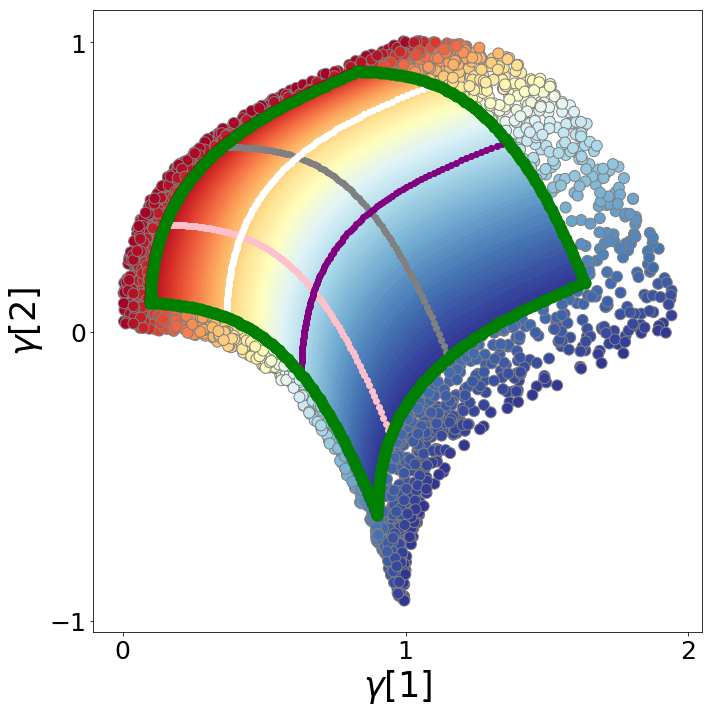

In [48]:
plt.figure(figsize=(10,10))
plt.scatter(recon[:,0],recon[:,1],c=x[:,0],cmap=cm,s=120, edgecolor='grey')

plt.scatter(emb_inter_recon[:,:,0],emb_inter_recon[:,:,1],c=x_inter[:,:,0],cmap=cm,s=120)

for index,i in enumerate([33,66,133,166]):
    plt.scatter(emb_inter_recon[i,:,0],emb_inter_recon[i,:,1], c=colors[index],  cmap=cm)    


plt.scatter(recon1[:,0],recon1[:,1], c='green',s=120)
plt.scatter(recon2[:,0],recon2[:,1], c='green',s=120)

plt.xlabel(r'$\gamma$[1]',fontsize=35)
plt.ylabel(r'$\gamma$[2]',fontsize=35)
plt.locator_params(nbins=4)

plt.tick_params(labelsize=25)
plt.tight_layout()


In [54]:
print('MSE dists- Interpolation: ')
print(np.mean((additionalDataY_inter-emb_inter_recon)**2))
print('Standard deviation of squared error reconstruction- Interpolation:')
print(np.std((additionalDataY_inter-emb_inter_recon)**2))


MSE dists- Interpolation: 
0.0001928581871160817
Standard deviation of squared error reconstruction- Interpolation:
0.0003355406896331616
